
The idea is that the change in sales is explained by the ad spend in tv, radio, and online and the change in price. Here there is no change in price, so it will not have an effect on sales. The goal is to explain how much each type of ad spend affect the sales per unit spent.

Upon inspection, the data is highly linear, so I will build a linear regression model. The sales variable is a linear combination of the ad spends and the price, and the model will try to find the weights that describe how much each ad spend affects the sales.

The weights represent how much an increase in ad spend will increase the sales. e.g. if tv_spend has a coefficient of 1.5, an increase of 1 unit in tv_spend will return an increase of 1.5 units in sales. 

The intercept represents the sales that would be made if there were no ad spends.

Furthermore models can produce some statistics that tell us how well they fit the data, such as $R^2$, MSE, and p-values. We want models with high $R^2$, low MSE, and reasonable p-values (>0.05).

In [36]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import statsmodels.api as sm

# Setting global plotting parameters
matplotlib.rcParams['figure.figsize'] = 14, 8
matplotlib.rcParams['font.size'] = 15

In [37]:
data = {
    'sales':        [200, 220, 250, 270, 290, 310, 330, 350, 370, 390],    
    'tv_spend':     [10, 15, 20, 25, 30, 35, 40, 45, 50, 55],
    'radio_spend':  [5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
    'online_spend': [20, 25, 30, 35, 40, 45, 50, 55, 60, 65],
    'price':        [100, 100, 100, 100, 100, 100, 100, 100, 100, 100]
}

df = pd.DataFrame(data)

# Define independent variables (X) and dependent variable (y)
X = df[['tv_spend', 'radio_spend', 'online_spend', 'price']]
y = df['sales']

### Ordinary least squares regression model

The ordinary least squares (OLS) regression model is the simplest model in the statsmodels library, and therefore a reasonable first try. It is a linear regression model that tries to minimize the sum of the squared differences between the observed and predicted values. The model is defined as:

$$\mathcal{L} = \sum_i^n{(y_i-\hat{y}_i)^2}$$

where $\hat{y}_i$ is the models prediction of the value $y_i$.

In [38]:
# Add a constant to the model to produce an intercept
X = sm.add_constant(X)#X.drop(['price'], axis=1))

# Fit the regression model
model = sm.OLS(y, X).fit()

# Display the summary of the regression model
print(model.summary())

# Extract coefficients
OLS_coeffs = model.params
r2_OLS = model.rsquared

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     3521.
Date:                Mon, 01 Jul 2024   Prob (F-statistic):           7.23e-12
Time:                        16:40:02   Log-Likelihood:                -24.736
No. Observations:                  10   AIC:                             53.47
Df Residuals:                       8   BIC:                             54.08
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
tv_spend         1.3725      0.024     57.288   

C:\Users\simon\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\stats\_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [39]:
df.corr()

,sales,tv_spend,radio_spend,online_spend,price
sales,1.000000,0.998866,0.998866,0.998866,NaN
tv_spend,0.998866,1.000000,1.000000,1.000000,NaN
radio_spend,0.998866,1.000000,1.000000,1.000000,NaN
online_spend,0.998866,1.000000,1.000000,1.000000,NaN
price,NaN,NaN,NaN,NaN,NaN


The coefficients are wrong. Price has the highest coefficient when it should be 0. The p-value for price should also not be below 0.05. As you then cannot reject the null hypothesis that the coefficient is 0. 

OLS is not a good model if two or more variables are correlated, and the correlation matrix shows that all variables are highly correlated.

# Regularized regression model

I introduce a regularization term to the model. 

Both have a standard OLS loss function

L1 (Lasso) has the added term $\alpha \sum{|w_i|}$ 

L2 (ridge) has $\alpha \sum{|w^2_i|}$.

$\alpha$ is a coefficient determining the strength of the regularization. $w_i$ are the weights of the model. The regularization of these models wil punish the models for needlessly large weights, and can hopefully reduce the coefficient of the price variable.

In [49]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=3, shuffle=False)

# Initialize the Ridge regression model
ridge = Ridge(
    alpha=3,
    fit_intercept=True, 
    copy_X=True, 
    max_iter=None, 
    tol=0.0001, 
    solver='auto', 
    positive=False, 
    random_state=None
)

# Train the model
ridge.fit(X_train, y_train)

# Make predictions
y_pred = ridge.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2_ridge = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f'R^2: {r2_ridge}')
ridge_coeffs = ridge.coef_
# Output the coefficients
print(f"Coefficients: {ridge_coeffs}")
print(f"Intercept: {ridge.intercept_}")


Mean Squared Error: 37.05200819198815
R^2: 0.8610549692800444
Coefficients: [1.45030908 1.45030908 1.45030908 0.        ]
Intercept: 151.11813056178227


# Now an elastic model

The elastic net model is a combination of the L1 and L2 models. It has two hyperparameters, $\alpha$ and $\rho$. $\alpha$ is the strength of the regularization, and $\rho$ is the ratio of the L1 and L2 regularization.

I tried tuning the parameters, but the output weights don't change much and are similar to the ones from the ridge model.

In [44]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import ElasticNet

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=3, shuffle=False)

# Initialize and train the Elastic Net model
alpha = 3.0  # Regularization strength
l1_ratio = 0.5  # Mix ratio between L1 and L2 regularization. 0 for ridge, 1 for lasso
elastic_net = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)

# Train the model
elastic_net.fit(X_train, y_train)

# Make predictions
y_pred = elastic_net.predict(X_test)

# Evaluate the model
mse_elastic = mean_squared_error(y_test, y_pred)
r2_elastic = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2: {r2}")

elastic_coeffs = elastic_net.coef_
# Output the coefficients
print(f"Coefficients: {elastic_coeffs}")
print(f"Intercept: {elastic_net.intercept_}")


Mean Squared Error: 32.747142791439664
R^2: 0.8939411469928911
Coefficients: [1.43528552 1.44050439 1.44468271 0.        ]
Intercept: 151.88673660735117


With the coefficients the total sales can be explained as a linear combination of the ad spends. The coefficients are the weights of the ad spends.

$$Sales = w_{tv}\cdot tv\_spend + w_{radio}\cdot radio\_spend + w_{online}\cdot online\_spend + intercept$$

where $w_{medium}$ is the weight/slope of the ad spend in the medium, and intercept is the sales with no ad spends.

The linear combination of the functions using the weights found by the models are overlaid the actual sales to compare.

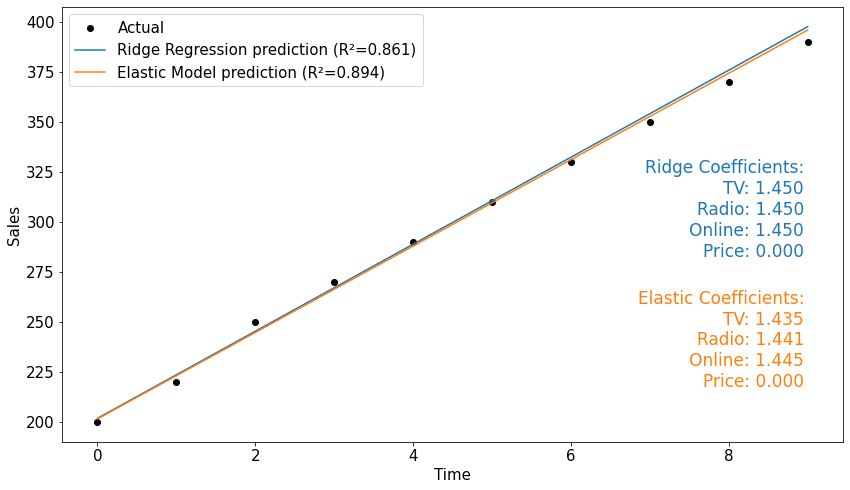

In [51]:
xax = np.arange(len(df))
plt.scatter(xax, df['sales'], color='k', label='Actual')
plt.plot(xax, ridge_coeffs@X.T + ridge.intercept_, label=f'Ridge Regression prediction (R²={r2_ridge:.3f})')
plt.plot(xax, elastic_coeffs@X.T + ridge.intercept_, label=f'Elastic Model prediction (R²={r2_elastic:.3f})')

# Textboxes
plt.text(0.95, 0.65, f'Ridge Coefficients:\nTV: {ridge_coeffs[0]:.3f}\nRadio: {ridge_coeffs[1]:.3f}\nOnline: {ridge_coeffs[2]:.3f}\nPrice: {ridge_coeffs[3]:.3f}',
         transform=plt.gca().transAxes, fontsize=17, verticalalignment='top', horizontalalignment='right', color='C0')
plt.text(0.95, 0.35, f'Elastic Coefficients:\nTV: {elastic_coeffs[0]:.3f}\nRadio: {elastic_coeffs[1]:.3f}\nOnline: {elastic_coeffs[2]:.3f}\nPrice: {elastic_coeffs[3]:.3f}',
         transform=plt.gca().transAxes, fontsize=17, verticalalignment='top', horizontalalignment='right', color='C1')


plt.ylabel('Sales')
plt.xlabel('Time')
plt.legend();

A high $R^2$ means that the model is a good fit, and that the independent variables can predict the dependent variable well. Low MSE means that the model is accurate. The models also pass the eye test.

The final weights: 

tv: 1.435

radio: 1.441 

online: 1.445 

price: 0